# Natural Language Processing for Classifying Amazon Reviews.
## Sentiment Analysis

Riccardo Romagnoli

## Setup Librerie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## NLTK

- _NLTK_ (_Natural Language Toolkit_) one of the primary lib in Python fr managing natual language data.

In [2]:
import nltk

- Some specific feature of nltk will be downloaded during the notebook with the function `download`. This data will be stored in the dir `nltk_data` in our home.

## Segmentation

- NLTK offers the `word_tokenize` function to decompose a string into a list of words and punctuation marks
- The function uses an English language model to correctly break down some words
- We use the `download` function to download that template (if not already downloaded)

In [3]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\98ric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Bag of Words e Vector Space Model

- We will make use of the model Bag of Words and Vector Space Model for keeping track of the occurencies for each word for each document.

## Case Study: Classification of Reviews

- Users' opinions are continuously published on the web, eg. of movies
   - some of these (e.g. on Amazon) are labeled with a number of stars, which indicate whether it is positive or negative
   - on others (eg messages on forums) we do not have this structured information, but only the text
- We want to train a classifier on reviews labeled as positive or negative, so that he is able to estimate the sentiment of untagged text
- We use a file of 10,000 movie reviews retreived from Amazon. Each review  has a rating from 1 to 5 stars
- Using the vector space model, we can train a model on the counts of all the words present in the documents

In [4]:
import os
if not os.path.exists("reviews.csv.gz"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/Jmwrd", "reviews.csv.gz")

In [5]:
reviews = pd.read_csv("reviews.csv.gz", sep="\t")

In [6]:
reviews.shape

(10000, 2)

- The file contains two columns
   - in `text` we find the text of the review
   - in `stars` we find the number of stars given by the user, from 1 to 5
- Let's look at some lines of the dataset; first let's increase the number of characters displayed per col

In [7]:
pd.options.display.max_colwidth = 100

In [8]:
reviews.tail(10)

,text,stars
9990,WHAT CAN I SAY THIS PPV WAS AWFUL WITH ONLY A FEW DECENT MATCHES.The best match was The stretche...,2
9991,"La Resistance vs Dudley boyz-Good tag team match up.There were great moves,good action and a sho...",4
9992,Dudley boyz vs French guys-Exellent tables match and a great opener.It was good to see all 3 mem...,5
9993,"Survivor series 2003 had alot on the line including jobs,titles and lives in the burried alive m...",4
9994,Dudley Boyz VS Ric Flair and Batista: This match was rather short. Dudley's looked good but Coac...,4
9995,"You seen one heist film, you seen them all. But every once in a while, somebody who really gives...",5
9996,"Often compared with ""The Big Chill"", and getting numerous stars in many reviews, this film simpl...",1
9997,This collection of Laurel and Hardy films contains five total selections. Four of these are sho...,3
9998,I love Vin Diesel but I wish I'd skipped this movie. The first bad sign was the fact that this t...,3
9999,"When The Office was first shown to a UK audience back in 2001, it was shown on BBC2. That is the...",5


## Exploratory data analysis

In [9]:
reviews["stars"].value_counts()

5    4708
4    2620
3    1434
2     704
1     534
Name: stars, dtype: int64

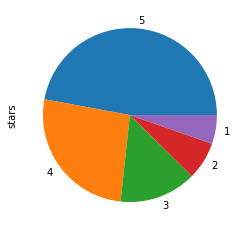

In [10]:
reviews["stars"].value_counts().plot.pie();

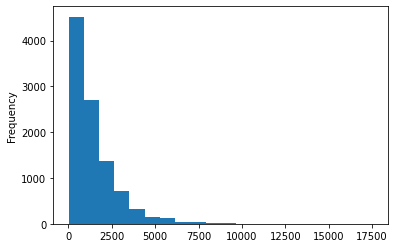

In [11]:
reviews["text"].str.len().plot.hist(bins=20);

## Suddivision in negative and positive reviews

- To simplify the analysis, we reduce the 5 possible star numbers to two classes

In [12]:
reviews["label"] = np.where(reviews["stars"] >= 4, "pos", "neg")

In [13]:
reviews["label"].value_counts()

pos    7328
neg    2672
Name: label, dtype: int64

## Classification of texts

- The documents-terms matrix has the form of a dataset
   - each line represents an example (a text) to be classified
   - each column represents a variable that characterizes the examples
- On this matrix we can then train a classifier to estimate the sentiment of the reviews
- Let's start by dividing the data into training set (70 \%) and validation set (30 \%)

In [14]:
from sklearn.model_selection import train_test_split
reviews_train, reviews_val = \
    train_test_split(reviews, test_size=0.3, random_state=42)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [16]:
dtm_train = vect.fit_transform(reviews_train["text"])

In [17]:
len(vect.get_feature_names())

51772

- Some examples of extracted words are...

In [18]:
vect.get_feature_names()[1000:1010]

['abides',
 'abiding',
 'abigail',
 'abilene',
 'abilites',
 'abilities',
 'ability',
 'abit',
 'abition',
 'abject']

 - We are working with sparse matrix as the percentage of non-zero elements is very low

In [19]:
dtm_train

<7000x51772 sparse matrix of type '<class 'numpy.int64'>'
	with 993179 stored elements in Compressed Sparse Row format>

In [20]:
dtm_train.astype(bool).mean()

0.002740529905850931

- Here we represent the documents of the valitation set trasforming the previous vectorial space, we get back the corrispondent matrix

In [21]:
dtm_val = vect.transform(reviews_val["text"])

- At this point we create a classification model and train it by passing the documents-terms matrix and the reviews labels related to the training set. We use logistic regression

In [22]:
from sklearn.linear_model import LogisticRegression
lrm = LogisticRegression(solver="saga", C=10)
lrm.fit(dtm_train, reviews_train["label"]);

c:\users\98ric\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


- We can estimate the accuracy using the validation labels:

In [23]:
lrm.score(dtm_val, reviews_val["label"])

0.7996666666666666

- The model assumes `neg` as _negative_ class (-1) and` pos` as _positive_ (1), as deduced from the order of the two in the attribute `classes_`

In [24]:
lrm.classes_

array(['neg', 'pos'], dtype=object)

## Use the model

- We can consider the following set of reviews to classify:

In [25]:
new_reviews = ["What an awesome movie!", "It was really boring"]

In [26]:
dtm_new = vect.transform(new_reviews)

In [27]:
lrm.predict(dtm_new)

array(['pos', 'neg'], dtype=object)

In [28]:
lrm.predict_proba(dtm_new)

array([[0.45271932, 0.54728068],
       [0.54860307, 0.45139693]])

## Better understanding the model: parameters

- We can access the linear coefficients assigned to the model for each term

In [29]:
lrm.coef_[0, :4]

array([ 0.00122182,  0.00551732,  0.00096862, -0.00018462])

- We can associate the feature name to the param

In [30]:
coefs = pd.Series(lrm.coef_[0], index=vect.get_feature_names())

- Sorting this series we can see which are the highest and lowest coefficients and from these: which words contribute most to make a positive or negative review.

In [31]:
coefs.sort_values(inplace=True)

In [32]:
coefs.head(10)

bad       -0.280119
nothing   -0.204467
worst     -0.183651
plot      -0.181641
just      -0.155580
if        -0.151799
boring    -0.138702
decent    -0.134982
minutes   -0.134170
but       -0.134041
dtype: float64

In [33]:
coefs.tail(10)

season       0.156078
very         0.167034
you          0.177193
well         0.180045
love         0.180249
highly       0.180372
excellent    0.204739
dvd          0.206031
best         0.213090
great        0.420797
dtype: float64

## Let's make use of a Pipeline for doing pre-processing

In [34]:
from sklearn.pipeline import Pipeline

In [35]:
model = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("classifier", LogisticRegression(solver="saga", C=10))
])

In [36]:
model.fit(reviews_train["text"], reviews_train["label"]);

c:\users\98ric\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [37]:
model.score(reviews_val["text"], reviews_val["label"])

0.8

In [38]:
pd.Series(
    model.named_steps["classifier"].coef_[0],
    index=model.named_steps["vectorizer"].get_feature_names()
).sort_values().tail(5)

highly       0.180323
excellent    0.204698
dvd          0.206369
best         0.213940
great        0.420778
dtype: float64

## tf.idf

- We can use _tf.idf_ (_term frequency-inverse document frequency_), to weigh the relevance of each term in a document
    - the _tf_ indicates the **local importance** of a term in a document and is equal to the number of occurrences (or its logarithm)
    - the_idf_ indicates the **global importance** of a term, the higher the more the term is less common in the overall set of documents
    - commonly, once all weights have been calculated, **each vector is normalized** in order to have Euclidean norm equal to 1, to smooth out differences in weights between short and long documents

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("classifier", LogisticRegression(solver="saga", C=10))
])

- Train a model on the training set and evaluate the accuracy:

In [41]:
model.fit(reviews_train["text"], reviews_train["label"])
model.score(reviews_val["text"], reviews_val["label"])

0.825

## Breakdown in terms with NLTK

- We can use the param `tokenizer` to specify a non standard logic to split the strings

In [42]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=nltk.word_tokenize)),
    ("classifier", LogisticRegression(solver="saga", C=10))
])
model.fit(reviews_train["text"], reviews_train["label"])
model.score(reviews_val["text"], reviews_val["label"])

0.8223333333333334

- We actually get a slightly less accurate model

## Reduce dimensionality

- The number of dimensions generated considering all the distinct terms present in all the documents, as also seen above, is very high. That can cause a longer execution time and an excessive use of memory. We will now try to reduce the dimensionality without loosing too much accuracy.

In [43]:
len(model.named_steps["vectorizer"].get_feature_names())

72503

- We can set the parameter `min_df` in `TfidfVectorizer` (or `CountVectorizer`) to limit the words in the vector space dictionary to those present in at least _N_ training documents

In [44]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(min_df=3)),
    ("classifier", LogisticRegression(solver="saga", C=10))
])
model.fit(reviews_train["text"], reviews_train["label"]);

- We just N = 3 we obtain a much lighter model: 

In [45]:
len(model.named_steps["vectorizer"].get_feature_names())

21063

- While keeping the same accuracy

In [46]:
model.score(reviews_val["text"], reviews_val["label"])

0.8226666666666667

## Stopword removal

- We use NLTK lists to remove stopwords: terms that doen't add any informative content (articles, prepositions, coniugations)

In [47]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\98ric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
stoplist = nltk.corpus.stopwords.words("english")

In [49]:
stoplist[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

- We use the param _stop_words_ to insert our list of stopwords we want to remove from the feature set

In [50]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(min_df=3, stop_words=stoplist)),
    ("classifier", LogisticRegression(solver="saga", C=10))
])
model.fit(reviews_train["text"], reviews_train["label"]);

- We get a lower feature set in change of some points in accuracy

In [51]:
len(model.named_steps["vectorizer"].get_feature_names())

20922

In [52]:
model.score(reviews_val["text"], reviews_val["label"])

0.809

## Grid search to find best hyperparameters
Here we are testing:
    - minimum number of documents in which a word must appear: 3, 5 or 10
    - removal/no removal of stopwords

In [53]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [54]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("classifier", LogisticRegression(solver="saga", C=10))
])
grid = {
    "vectorizer__min_df": [3, 5, 10],
    "vectorizer__stop_words": [None, stoplist]
}
skf = StratifiedKFold(3, shuffle=True)
gs = GridSearchCV(model, grid, cv=skf)
gs.fit(reviews_train["text"], reviews_train["label"]);

In [55]:
gs.score(reviews_val["text"], reviews_val["label"])

0.8226666666666667

## n-gram

- A _n-gram_ is a **sequence of consecutive words** in a text, we can specify that in order to consider words that make sense taking togheder.
- Drawback -> higher dimensionality

In [56]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(min_df=3, ngram_range=(1, 2))),
    ("classifier", LogisticRegression(solver="saga", C=10))
])
model.fit(reviews_train["text"], reviews_train["label"]);

In [57]:
len(model.named_steps["vectorizer"].get_feature_names())

100711

In [58]:
model.score(reviews_val["text"], reviews_val["label"])

0.8233333333333334

In [59]:
model.named_steps["vectorizer"].get_feature_names()[-15:-5]

['zone and',
 'zone feel',
 'zone the',
 'zones',
 'zoo',
 'zooey',
 'zooey deschanel',
 'zoolander',
 'zoom',
 'zooming']

## POS Tagging

- We try to add the _Part of Speech_ (POS) information to the token as a tupla

In [60]:
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\98ric\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [61]:
def tokenize_with_pos(text):
    return nltk.pos_tag(nltk.tokenize.word_tokenize(text))

In [62]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(min_df=3, tokenizer=tokenize_with_pos)),
    ("classifier", LogisticRegression(solver="saga", C=10))
])
model.fit(reviews_train["text"], reviews_train["label"]);

In [63]:
len(model.named_steps["vectorizer"].get_feature_names())

26839

In [64]:
model.score(reviews_val["text"], reviews_val["label"])

0.8156666666666667

- Not much difference 

## Lemmatization

- With lemmatization we **group similar terms** under the same word. By doing that we reduce the dimensionality of the space without loss of relevant information
- To perform the lemmatization in NLTK we create a `WordNetLemmatizer` object and we also need to download the WordNet knowledge base, which includes the necessary information

In [65]:
nltk.download("wordnet")
wnl = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\98ric\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


- To lemmatize a word, use the `lemmatize` method, passing also the POS (n = noun, v = verb, a = adjective, r = adverb)
- We create a function that segments the words of a text by performing lemmatization where possible
- we create a dictionary with the correspondences between the first letters of the POS in Penn Treebank

In [66]:
penn_to_wn = {"N": "n", "V": "v", "J": "a", "R": "r"}
def tokenize_with_lemmatization(text):
    return [(wnl.lemmatize(token, penn_to_wn[tag[0]]) if tag[0] in penn_to_wn else token)
            for token, tag in nltk.pos_tag(nltk.tokenize.word_tokenize(text))]

In [67]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(min_df=3, tokenizer=tokenize_with_lemmatization)),
    ("classifier", LogisticRegression(solver="saga", C=10))
])
model.fit(reviews_train["text"], reviews_train["label"]);

- As a result we get a lower number of features, however the time taken for processing the text is higher

In [68]:
len(model.named_steps["vectorizer"].get_feature_names())

18152

In [69]:
model.score(reviews_val["text"], reviews_val["label"])

0.82

## Stemming

We use A _stemming_ algorithm to extracts the **morphological root** of a word, which results in:
    - terms with the same root are often correlated, although they are different terms (eg name "fish" and verb "fishing")
    - stemming does not require POS tagging and is generally much more efficient
- NLTK integrates several stemming algorithms, including eg. `PorterStemmer`

In [70]:
ps = nltk.stem.PorterStemmer()
ps.stem("lemmatization"), ps.stem("lemmatizer"), ps.stem("lemmatize")

('lemmat', 'lemmat', 'lemmat')

In [71]:
def tokenize_with_stemming(text):
    return [ps.stem(token) for token
            in nltk.word_tokenize(text)]
    # or: return list(map(ps.stem, nltk.word_tokenize(text)))

In [72]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(min_df=3, tokenizer=tokenize_with_stemming)),
    ("classifier", LogisticRegression(solver="saga", C=10))
])
model.fit(reviews_train["text"], reviews_train["label"]);

In [73]:
len(model.named_steps["vectorizer"].get_feature_names())

15926

In [74]:
model.score(reviews_val["text"], reviews_val["label"])

0.8223333333333334

We managed to have an even lower in dimensionality without losing accuracy at all.

## Sentiment Analysis in NLTK

- Estimating the positive or negative orientation of written opinions is a very common problem
- There are pre-trained models for this, including [_VADER_] (https://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/viewPaper/8109) (_Valence Aware Dictionary and sEntiment Reasoner_)
- NLTK allows us to use VADER to evaluate the orientation of opinions, without the need to train models
- To use VADER, we download the necessary data and create a `SentimentIntensityAnalyzer` object. We then will predict our evaluation instances and compare the accuracy with our model

In [75]:
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\98ric\AppData\Roaming\nltk_data...


We created a function in order to use VANDER in our specific use case. That function will sum all the compount (one of the return values from _vader.polarity_scores_) result for each sentence of each text. If the value is positive then the sentiment is positive, negative elsewhere.

In [76]:
from sklearn.metrics import accuracy_score

In [77]:
def label_review(review):
    sentences = nltk.sent_tokenize(review)
    scores = list(map(vader.polarity_scores, sentences))
    return "pos" if sum(s["compound"] for s in scores) >= 0 else "neg"

In [78]:
vader_preds = [label_review(review) for review in reviews_val["text"]]

In [79]:
accuracy_score(reviews_val["label"], vader_preds)

0.7303333333333333

Our model actually performs better, but we also have to say that VANDER is majorly trained on twitter messages while out model right on the data in question.